# IMPORTS Y PACKAGES

In [1]:
#Packages to install

#!pip install pandas
#!pip install numpy
#!pip install scipy
#!pip install matplotlib
#!pip install scikit-learn
#!pip install ipywidgets
#!pip install panel --user

In [2]:
#Imports

import math
import time as time
import pandas as pd
import numpy as np
import scipy as sp
import random as rd
import ipywidgets as widgets
import panel as pn
from ipywidgets import HBox, VBox, interact, interact_manual,interactive
from IPython.display import display,clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import deepcopy
from sklearn import preprocessing

#Interactive plot
#%matplotlib notebook
#%matplotlib inline

# CLASES

## Clases para generar y mostrar ejemplos

In [3]:
class DataSet:
    
    data = []
    list_points = []
    drawPoint = []
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.__read(',')
        
    #Derived
    def __read(self, sep):
        
        self.data = pd.read_csv(self.file_path, sep=sep,encoding='utf8')
        self.drawPoint = []
        points = []
        allX = []
        allY =[]
                
        for index, row in self.data.iterrows():
            p = Point(row['Coord X'],row['Coord Y'])
            points.append(p)
            allX.append(p.x)
            allY.append(p.y)
        
        self.list_points = points
        self.drawPoint.append(allX)
        self.drawPoint.append(allY)
        
        return self.list_points
        
    def drawData(self, drawType):       
        plt.plot(self.drawPoint[0],self.drawPoint[1],drawType)

In [4]:
class Canvas:
    
    width = 0
    height = 0
    data = []
    points = []

    def __init__(self, width, height, data):
        self.width = width
        self.height = height
        self.data = data
        self.points = self.__dataToPoints()
   
    #Derived
    def __dataToPoints(self):
        res = []        
        for i in range (0,len(self.data)):            
            for j in range(0,self.data[i].numOfPoints):                
                point=[]
                point.append(self.data[i].xVals[j])
                point.append(self.data[i].yVals[j])              
                point.append("Circulo"+str(i+1))
                
                res.append(point)
        return res
    
    def RawPoints(self,rawData):
        
        aux = []
        res = []
        
        for i in range (0,len(rawData)):
            
            aux.append(rawData[i].x)
            aux.append(rawData[i].y)
            
            res.append(aux)
            
            aux = []
            
        self.points = res;
    
    def drawData(self):
        for i in range (0,len(self.points)):
            plt.plot(self.points[i][0],self.points[i][1],'ro')
            
    def drawDataPlot(self):
        
        xs = []
        ys = []
        
        for i in range (0,len(self.points)):
            xs.append(self.points[i][0])
            ys.append(self.points[i][1])
        
        return self.data,xs,ys
    
    def removeRandomPoints(self,percentage):
        
        if len(self.points) != 0:
            pointsToRemove = int(len(self.points)*percentage)
            newArrayLen = len(self.points)

            for i in range (0, pointsToRemove):
                j = rd.randint(0,newArrayLen-1)
                self.points.pop(j)
                newArrayLen -= 1
        else:
            print("Data debe tener al menos un punto.")
    
    def insertNoise(self,devX,devY):
        noiseX = np.random.normal(0,devX,len(self.points))
        noiseY = np.random.normal(0,devY,len(self.points))
        
        for i in range(0,len(self.points)):
            self.points[i][0] += noiseX[i]
            self.points[i][1] += noiseY[i]
            
    def drawRandomCirclesRandomRadius(self,numOfCircles,precision):
            
        for i in range (0,numOfCircles):
            
            maxRad = 0
            
            if(self.width > self.height):
                maxRad = self.height/2
            else:
                 maxRad = self.width/2
            
            radius = rd.uniform(1,maxRad)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)
                       
            c = Circle(Point(centerX,centerY),radius,precision)
            self.data.append(c)
            c.draw()
        
        self.points = self.__dataToPoints()
            
    def drawRandomCirclesRadiusRange(self,numOfCircles, minRadius, maxRadius, precision):
            
        for i in range (0,numOfCircles):
                       
            radius = rd.uniform(minRadius,maxRadius)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)                       
            c = Circle(Point(centerX,centerY),radius,precision)
            
            self.data.append(c)
            c.draw()
            
        self.points = self.__dataToPoints()
        
    def drawRandomCirclesRadiusRangePlot(self,numOfCircles, minRadius, maxRadius, precision):
            
        for i in range (0,numOfCircles):
                       
            radius = rd.uniform(minRadius,maxRadius)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)                       
            c = Circle(Point(centerX,centerY),radius,precision)
            
            self.data.append(c)
            
        self.points = self.__dataToPoints()

## Clases del dominio del problema

In [5]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def getFurthestPoint(self,points):
        
        res = Point(0,0)
        auxDis = 0.0
        
        for i in range(0,len(points)):
            dis = self.calculateDistanceToPoint(points[i])
            
            if(dis>auxDis):
                auxDis = dis
                res = points[i]
            
        return res
    
    def calculateDistanceToCluster(self,c):
        dis = self.calculateDistanceToPoint(c.center)
        return abs(dis - c.radius)
    
    def calculateDistanceToCluster_noAbs(self,c):
        dis = self.calculateDistanceToPoint(c.center)
        return dis - c.radius
    
    def calculateThreshold(self,circles):
        
        distances = []
        distances_n = []
        
        for i in range(0,len(circles)):
            distances.append(self.calculateDistanceToCluster(circles[i]))
                
        mod = 0.000000000000000000001
        for i in range(0,len(distances)):
            mod += distances[i]
            
        distances_n = (mod - np.array(distances))*(1/mod)
        
        return distances_n
    
    def calculatePerpendicular(self,p):
        
        precision = 0.000001
        
        #Punto medio
        xMean = (self.x + p.x)/2
        yMean = (self.y + p.y)/2
        
        if(p.y - self.y == 0):
            self.y += precision
        
        if(p.x - self.x == 0):
            self.x += precision
        
        #Pendiente usando: y - y1 = m(x - x1) y  mp = -1/m
        m = -1/((p.y - self.y)/(p.x - self.x))
        
        #Se devuelve [x,y,b]
        perpendicular = ([-m,1,m*(-xMean)+yMean])
        
        return perpendicular
    
    def calculateDistanceToPoint(self,p):
        disX = p.x - self.x
        disY = p.y - self.y
        dis = math.sqrt(disX*disX + disY*disY)
        
        return dis
    
    def equals(self,p):
        if(self.x == p.x and self.y == p.y):
            return 1
        else:
            return 0
        
    def print(self):
        print("(",self.x,",",self.y,")")

In [6]:
class Circle:
    
    center = 0
    radius = 0
    numOfPoints = 0
    xVals = []
    yVals = []
    
    def __init__(self, center, radius, numOfPoints):
        self.center = center
        self.radius = radius
        self.numOfPoints = numOfPoints
        self.__calculate()
      
    #Derived
    def __calculate(self):
        
        self.xVals = []
        self.yVals = []
        
        alpha = 2*math.pi/self.numOfPoints
        i = 0     
        while i < 2*math.pi:
            self.xVals.append(self.center.x + self.radius*math.cos(i))
            self.yVals.append(self.center.y + self.radius*math.sin(i))
            i += alpha
            
    def update(self, center, radius):
        self.center = center
        self.radius = radius
        self.__calculate()
    
    def draw(self):
        if(len(self.xVals) == 0 or len(self.yVals) == 0):
            print('Error when drawing: Values are empty')
        else:
            xPrimeVals = self.xVals
            xPrimeVals.append(xPrimeVals[0])
            
            yPrimeVals = self.yVals
            yPrimeVals.append(yPrimeVals[0])
            
            plt.plot(xPrimeVals,yPrimeVals)
            plt.plot(self.center.x,self.center.y,'bo')
    
    def drawPlot(self):
        
        fig = plt.figure('fig')
        ax = fig.add_subplot(111)
                
        if(len(self.xVals) == 0 or len(self.yVals) == 0):
            print('Error when drawing: Values are empty')
        else:
            xPrimeVals = self.xVals
            xPrimeVals.append(xPrimeVals[0])
            
            yPrimeVals = self.yVals
            yPrimeVals.append(yPrimeVals[0])
            
            ax.plot(xPrimeVals,yPrimeVals)
            ax.plot(self.center.x,self.center.y,'bo')
            
            return fig,ax
            
    def drawSubplot(self,axs,it):
        if(len(self.xVals) == 0 or len(self.yVals) == 0):
            print('Error when drawing: Values are empty')
        else:
            xPrimeVals = self.xVals
            xPrimeVals.append(xPrimeVals[0])
            
            yPrimeVals = self.yVals
            yPrimeVals.append(yPrimeVals[0])
            
            axs[it].plot(xPrimeVals,yPrimeVals)
            axs[it].plot(self.center.x,self.center.y,'bo')
            
    def calculateFrom3Points(p1,p2,p3):
        #Mediatrices
        perp1 = p1.calculatePerpendicular(p2)
        perp2 = p1.calculatePerpendicular(p3)
        
        #Circuncentro
        A = [[perp1[0],perp1[1]],[perp2[0],perp2[1]]]
        
        if(np.linalg.det(A)==0):
            return Point(0,0),-1
        else:
            B = [[perp1[2]],[perp2[2]]]
            X = np.linalg.solve(A,B)
            circumcenter = Point(X[0],X[1])

            #Radio
            radius = circumcenter.calculateDistanceToPoint(p1)

            return circumcenter, radius
        
    def calculateBarycentre(list_points):
        
        sumX = 0
        sumY = 0
        radius = 0
        
        for i in range(0,len(list_points)):
            sumX = sumX + list_points[i].x
            sumY = sumY + list_points[i].y
        
        center = Point(sumX/len(list_points),sumY/len(list_points))
        
        for i in range(0,len(list_points)):
            radius = radius + center.calculateDistanceToPoint(list_points[i])
        
        radius = radius/len(list_points)
        
        return center,radius

## Clases del algoritmo

In [7]:
class ClusteringSolver:
    
    clusters = []
    thresholdValues = []
    
    list_points = []
    setData = []

    numCluster = 0
    
    sol_clusters = []
    sol_threshold = []
    
    def __init__(self,file_path,numCluster):
        
        self.clusters = []
        self.list_points = []
        
        self.numCluster = numCluster
        
        self.setData = DataSet(file_path)
        self.list_points = self.setData.list_points
                    
    def initRandomCluster(self):
        
        aux_cluster_init = []
            
        for i in range(0,self.numCluster):
                            
            #Pick Random Point
            indexOfRandomPoint = rd.randint(0,len(self.list_points)-1)
            RandomPoint = self.list_points[indexOfRandomPoint]
            RandomRadius =  rd.uniform(1,10)

            c = Circle(RandomPoint,RandomRadius,20)            
            aux_cluster_init.append(c)

        self.clusters = aux_cluster_init
    
    def calculateThreshold(self):
        
        threshold = []
        
        for i in range(0,len(self.setData.list_points)):
            p = self.setData.list_points[i]
            threshold.append(p.calculateThreshold(self.clusters))
        
        return self.getAssignedCluster(threshold)
       
    def getAssignedCluster(self, threshold):
    
        assignedCluster = []  
        
        for i in range(0,len(threshold)):
            tuplePointCircle = []
            index = 0
            auxVal = 0
            point = Point(0,0)
            
            for j in range(0,len(threshold[i])):
                if(j==0):
                    auxVal = threshold[i][j]
                    point = self.setData.list_points[i]
                    index = j
                else:
                    if(threshold[i][j] > auxVal):
                        auxVal = threshold[i][j]
                        point = self.setData.list_points[i]
                        index = j
                        
            tuplePointCircle.append(point)
            tuplePointCircle.append(index)
            assignedCluster.append(tuplePointCircle)
            
            tuplePointCircle = []
            index = 0
            point = Point(0,0)
            auxVal = 0
    
        return assignedCluster
    
    def calculateBestFitPoints(self,listOfPoints):     
   
        randomVals = rd.sample(listOfPoints,3)
        
        return randomVals[0],randomVals[1],randomVals[2]
    
    def calculateCircunference(self,mode,listOfPoints):
        
        if len(listOfPoints) == 0:
            center = Point(0,0)
            radius = -1
        else:
            if mode == 'c' and len(listOfPoints)>2:            
                radius = -1

                while radius == -1:
                    p1,p2,p3 = self.calculateBestFitPoints(listOfPoints)
                    center, radius = Circle.calculateFrom3Points(p1,p2,p3)        
            else:
                    center, radius = Circle.calculateBarycentre(listOfPoints)  
        
        return center, radius
        
    def learn(self,generations,precision,limit,mode):
        
        generation_cluster = []
        auxThreshold = []
        auxDist = 0       
        count = 0
        
        animData = []
        bestGeneration = 0

        while count < generations:
            #Animation
            animData.append([])
            
            #Initilization
            self.initRandomCluster()
            
            #Iterations
            nextIteration = 1
            previousState = []
            
            lim_it = 0
            while nextIteration == 1:
                            
                #Save Initial Status
                previousState = deepcopy(self.clusters)
                                
                data_to_cluster = []
                data = self.calculateThreshold()
                            
                for k in range(0,len(self.clusters)):
                                       
                    cluster = []
                           
                    for z in range(0,len(data)):
                                                
                        if(k == data[z][1]):
                            p = Point(data[z][0].x,data[z][0].y)
                            cluster.append(p)
                           
                    data_to_cluster.append(cluster)
                
                dirty = 0
                for k in range(0,len(data_to_cluster)):
                    c,r = self.calculateCircunference(mode,data_to_cluster[k])
                    
                    if r == -1:
                        count -= 1
                        dirty = 1
                        break
                        
                    self.clusters[k].update(c,r)
            
                if dirty == 1:
                    break
                    
                #Check Centres
                                
                dirty_it = 0
                for j in range(0,len(previousState)):
                    
                    p_center = previousState[j].center
                    p_radius = previousState[j].radius
                    
                    a_center = self.clusters[j].center
                    a_radius = self.clusters[j].radius
                    
                    cond_center = p_center.calculateDistanceToPoint(a_center) > precision
                    cond_radius = abs(p_radius - a_radius) > precision

                    #Check cond
                    if cond_center or cond_radius:
                        dirty_it = 1
                
                if(dirty_it == 0 or lim_it == limit):                   
                    nextIteration = 0
                
                #Animation
                animClusters = deepcopy(self.clusters)
                animData[count].append([lim_it,animClusters,data])        
                
                lim_it += 1
            
            #Check Best Generation
            if count <= 0:
                generation_cluster = self.clusters
                auxThreshold = data
                
                for j in range(0,len(auxThreshold)):
                    auxDist += auxThreshold[j][0].calculateDistanceToCluster(generation_cluster[auxThreshold[j][1]])
            else:
                temp_cluster = self.clusters
                temp_threshold = data
                dist = 0
                for j in range(0,len(temp_threshold)):
                    dist += temp_threshold[j][0].calculateDistanceToCluster(temp_cluster[temp_threshold[j][1]])
                
                if(dist < auxDist):
                    generation_cluster = temp_cluster
                    auxThreshold = temp_threshold
                    auxDist = dist
                    bestGeneration = count
            
            count += 1
        
        self.sol_clusters = generation_cluster
        self.sol_threshold = auxThreshold
        
        return generation_cluster,auxThreshold,animData,bestGeneration

In [8]:
class Solution:
    
    cluster_solver = 0
    final_clusters = []
    final_threshold = []
    
    def __init__(self, cluster_solver):
        
        self.cluster_solver = cluster_solver
        
        self.final_clusters = self.cluster_solver.sol_clusters
        self.final_threshold = self.cluster_solver.sol_threshold
       
    def eraseNoise(self,minThreshold):
        
        point_to_erase = []
        
        for i in range(len(self.final_threshold)-1,-1,-1):
            
            threshold = self.final_threshold[i][0].calculateThreshold(self.final_clusters)
            
            if(threshold[self.final_threshold[i][1]] < minThreshold):
                point_to_erase.append(i)
                               
        for i in range(0,len(point_to_erase)):
            self.final_threshold.pop(point_to_erase[i])
        
    def drawSolution(self,minDistanceErase):
        
        self.eraseNoise(minDistanceErase)
        
        for i in range (0,len(self.final_clusters)):
            self.final_clusters[i].draw()

        for i in range(0,len(self.final_threshold)):
            if(self.final_threshold[i][1] == 0):
                plt.plot(self.final_threshold[i][0].x,self.final_threshold[i][0].y,'go')
            elif(self.final_threshold[i][1] == 1):
                plt.plot(self.final_threshold[i][0].x,self.final_threshold[i][0].y,'ko')
            elif(self.final_threshold[i][1] == 2):
                plt.plot(self.final_threshold[i][0].x,self.final_threshold[i][0].y,'ro')
            elif(self.final_threshold[i][1] == 3):
                plt.plot(self.final_threshold[i][0].x,self.final_threshold[i][0].y,'co')
            elif(self.final_threshold[i][1] == 4):
                plt.plot(self.final_threshold[i][0].x,self.final_threshold[i][0].y,'mo')
            elif(self.final_threshold[i][1] == 5):
                plt.plot(self.final_threshold[i][0].x,self.final_threshold[i][0].y,'yo')
            else:
                plt.plot(self.final_threshold[i][0].x,self.final_threshold[i][0].y,'0.5')
                
    def drawBestGeneration(self,animData,bestGeneration,figx,figy):
        
        fig, axs = plt.subplots(len(animData[bestGeneration]),figsize=(figx,figy))

        for j in range(0,len(animData[bestGeneration])):
            iterationClusters = animData[bestGeneration][j][1]
            iterationThreshold = animData[bestGeneration][j][2]
            
            for k in range (0,len(iterationClusters)):
                iterationClusters[k].drawSubplot(axs,j)
            
            for i in range(0,len(iterationThreshold)):
                
                if(iterationThreshold[i][1] == 0):
                    axs[j].plot(iterationThreshold[i][0].x,iterationThreshold[i][0].y,'go')
                elif(self.final_threshold[i][1] == 1):
                    axs[j].plot(iterationThreshold[i][0].x,iterationThreshold[i][0].y,'ko')
                elif(self.final_threshold[i][1] == 2):
                    axs[j].plot(iterationThreshold[i][0].x,iterationThreshold[i][0].y,'ro')
                elif(self.final_threshold[i][1] == 3):
                    axs[j].plot(iterationThreshold[i][0].x,iterationThreshold[i][0].y,'co')
                elif(self.final_threshold[i][1] == 4):
                    axs[j].plot(iterationThreshold[i][0].x,iterationThreshold[i][0].y,'mo')
                elif(self.final_threshold[i][1] == 5):
                    axs[j].plot(iterationThreshold[i][0].x,iterationThreshold[i][0].y,'yo')
                else:
                    axs[j].plot(iterationThreshold[i][0].x,iterationThreshold[i][0].y,'0.5')
    

# EJEMPLOS
## Generador de Ejemplos
### Generamos un Canvas de ejemplo

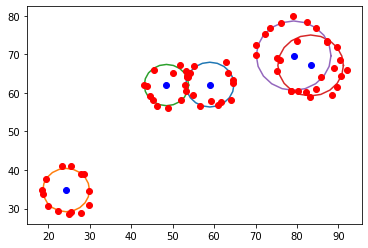

In [188]:
canvas = Canvas(100,100,[])
canvas.drawRandomCirclesRadiusRange(5,5,10,20)
canvasCopy = deepcopy(canvas)
canvas.removeRandomPoints(0.3)
canvas.insertNoise(0.5,0.9)
canvas.drawData()

In [202]:
canvas2 = deepcopy(canvasCopy)

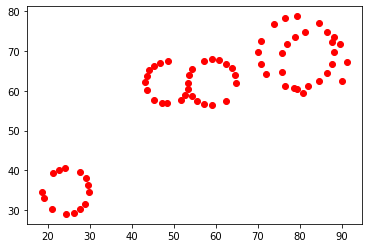

In [203]:
canvas2.removeRandomPoints(0.3)
canvas2.insertNoise(0.1,0.1)
canvas2.drawData()

### Guardamos el Canvas en un archivo Excel


In [176]:
file_path_ex = r"Datos/canvas_export2.csv"
headers = ['Coord X','Coord Y', 'Circulo']
df = pd.DataFrame(canvas.points, columns= headers)
df = df.sample(frac=1)
df.to_csv(file_path_ex, columns=headers, index=False, encoding="utf8")

### Convertimos el archivo Excel en un DataSet y mostramos los datos

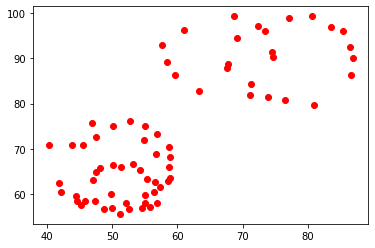

In [167]:
setData = DataSet(file_path_ex)
setData.drawData('ro')

### Ejecutamos el algoritmo y mostramos la solución
<ol>
<li>Instaciamos un objeto ClusteringSolver con el archivo Excel y el número de clusters.</li>
<li>Ejecutamos el algoritmo.</li>
<li>Instaciamos un objeto Solution con el resultado del algoritmo.</li>
<li>Mostramos la solución eliminando el ruido que deseemos.</li>
</ol>

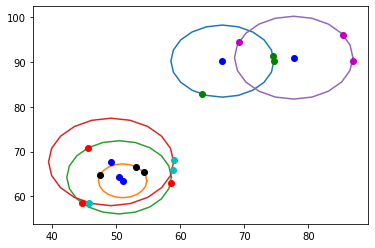

In [172]:
csExample = ClusteringSolver(file_path_ex,5)
final_clusters_ex,final_threshold_ex,anim_data,bestGeneration_ex = csExample.learn(250,1,50,'c')
solEx = Solution(csExample)
solEx.drawSolution(0.9999)

## Ejemplos aportados por el tutor
### Ejemplo 1

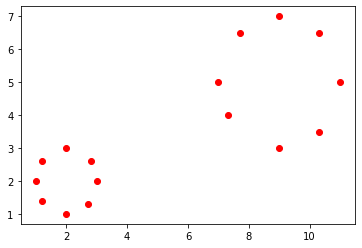

In [156]:
file_path1 = r"Datos/datos_prueba_1.csv"
setData = DataSet(file_path1)
setData.drawData('ro')

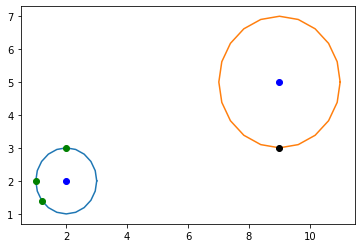

In [157]:
cs1 = ClusteringSolver(file_path1,2)
final_clusters1,final_threshold1,animData1,bestGeneration1 = cs1.learn(10,0.01,50,'c')
sol1 = Solution(cs1)
sol1.drawSolution(1)

### Ejemplo 2

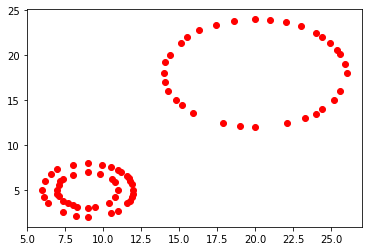

In [63]:
file_path2 = r"C:Datos/datos_prueba_2.csv"
setData = DataSet(file_path2)
setData.drawData('ro')

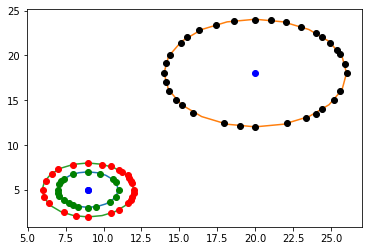

In [162]:
cs2 = ClusteringSolver(file_path2,3)
final_clusters2,final_threshold2,animData2,bestGeneration2 = cs2.learn(20,1,50,'c')
sol2 = Solution(cs2)
sol2.drawSolution(0.95)

## Traza de la mejor generación

In [173]:
#sol1.drawBestGeneration(animData1,bestGeneration1,6,10)
#sol2.drawBestGeneration(animData2,bestGeneration2,6,100)

## UI

In [9]:
class generateUI():
    
    canvasCC = Canvas(100,100,[])
            
    def createAndSolve(self):
        
        filePath = widgets.Text(
            value='',
            placeholder='C:..',
            description='File Path:',
            disabled=False
        )
        
        canvasMaxX = widgets.IntSlider(
            value = 100,
            min = 1,
            max = 500,
            description = 'Max X:',
            orientation = 'horizontal'
        )

        canvasMaxY = widgets.IntSlider(
            value = 100,
            min = 1,
            max = 500,
            description = 'Max Y:',
            orientation = 'horizontal'
        )

        numCircles = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 10,
            description = 'Nº Circles:',
            orientation = 'horizontal'
        )
                
        numCirclesSol = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 10,
            description = 'Nº Circles:',
            orientation = 'horizontal'
        )

        rangeRadius = widgets.IntRangeSlider(
            value = [5,10],
            min = 1,
            max = 10,
            description = 'Radius:',
            orientation = 'horizontal'
        )

        circlePrecision = widgets.IntSlider(
            value = 20,
            min = 1,
            max = 20,
            description = 'Circle Precision:',
            orientation = 'horizontal'
        )

        removePercentage = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1,
            step = 0.1,
            description = 'Remove %:',
            orientation = 'horizontal'
        )

        noisePercentage = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1.5,
            step = 0.1,
            description = 'Noise %:',
            orientation = 'horizontal'
        )

        genNumber = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 500,
            description = 'Generations:',
            orientation = 'horizontal'
        )

        precisionSolver = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1,
            step = 0.1,
            description = 'Precision:',
            orientation = 'horizontal'
        )

        maxLimitIt = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 50,
            description = 'Max It:',
            orientation = 'horizontal'
        )

        mode = widgets.SelectMultiple(
            options=['b','c'],
            value=['b'],
            description='Mode',
            disabled=False
        )

        noiseReduction = widgets.FloatSlider(
            value = 0.1,
            min = 0.850,
            max = 1,
            step = 0.001,
            readout_format='.3f',
            description = 'Threshold:',
            orientation = 'horizontal'
        )
                
        @interact_manual(nc=numCircles,rd=rangeRadius,cp=circlePrecision)
        def generate(nc,rd,cp):

            global canvasCC
            plt.figure(2)

            canvas = Canvas(100,100,[])
            canvas.drawRandomCirclesRadiusRangePlot(nc,rd[0],rd[1],cp)

            canvasCC = deepcopy(canvas)

            clusters,xs,ys = canvas.drawDataPlot()

            for i in range(0,len(clusters)):
                clusters[i].draw()

            plt.plot(xs,ys,'ro')
            plt.show()

        @interact_manual(fp=filePath,rp=removePercentage,nop=noisePercentage)
        def edit(fp,rp,nop):
            plt.figure(2)

            edit_canvas = deepcopy(canvasCC)
            edit_canvas.removeRandomPoints(rp)
            edit_canvas.insertNoise(nop,nop)

            clusters,xs,ys = edit_canvas.drawDataPlot()

            for i in range(0,len(clusters)):
                clusters[i].draw()

            plt.plot(xs,ys,'ro')
            plt.show()

            file_path_ex = fp
            headers = ['Coord X','Coord Y', 'Circulo']
            df = pd.DataFrame(edit_canvas.points, columns= headers)
            df = df.sample(frac=1)
            df.to_csv(file_path_ex, columns=headers, index=False, encoding="utf8")

            setData = DataSet(file_path_ex)

        @interact_manual(gn=genNumber,nc=numCirclesSol,p=precisionSolver,mxL=maxLimitIt,m=mode,nr=noiseReduction)
        def solve(gn,nc,p,mxL,m,nr):

            file_path_ex = filePath.value
            csExample = ClusteringSolver(file_path_ex,nc)
            final_clusters_ex,final_threshold_ex,animData_ex,bestGeneration_ex = csExample.learn(gn,p,mxL,m[0])
            solEx = Solution(csExample)
            solEx.drawSolution(nr)
            
    def loadAndSolve(self):
        
        filePath = widgets.Text(
            value='',
            placeholder='C:..',
            description='File Path:',
            disabled=False
        )
        
        numCircles = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 10,
            description = 'Nº Circles:',
            orientation = 'horizontal'
        )
        
        genNumber = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 500,
            description = 'Generations:',
            orientation = 'horizontal'
        )

        precisionSolver = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1,
            step = 0.1,
            description = 'Precision:',
            orientation = 'horizontal'
        )

        maxLimitIt = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 50,
            description = 'Max It:',
            orientation = 'horizontal'
        )

        mode = widgets.SelectMultiple(
            options=['b','c'],
            value=['b'],
            description='Mode',
            disabled=False
        )

        noiseReduction = widgets.FloatSlider(
            value = 0.1,
            min = 0.850,
            max = 1,
            step = 0.001,
            readout_format='.3f',
            description = 'Threshold:',
            orientation = 'horizontal'
        )
        
        removePercentage = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1,
            step = 0.1,
            description = 'Remove %:',
            orientation = 'horizontal'
        )

        noisePercentage = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1.5,
            step = 0.1,
            description = 'Noise %:',
            orientation = 'horizontal'
        )
        
        @interact_manual(fp=filePath)
        def edit_load(fp):
            
            setData = DataSet(fp)
            setData.drawData('ro')
            
        @interact_manual(gn=genNumber, nc=numCircles,p=precisionSolver,mxL=maxLimitIt,m=mode,nr=noiseReduction)
        def solve_load(gn,nc,p,mxL,m,nr):
            
            file_path_ex = filePath.value         
            csExample = ClusteringSolver(file_path_ex,nc)
            final_clusters_ex,final_threshold_ex,animData_ex,bestGeneration_ex = csExample.learn(gn,p,mxL,m[0])
            solEx = Solution(csExample)
            solEx.drawSolution(nr)
        

In [10]:
UI = generateUI()
UI.createAndSolve()

interactive(children=(IntSlider(value=1, description='Nº Circles:', max=10, min=1), IntRangeSlider(value=(5, 1…

interactive(children=(Text(value='', description='File Path:', placeholder='C:..'), FloatSlider(value=0.1, des…

interactive(children=(IntSlider(value=1, description='Generations:', max=500, min=1), IntSlider(value=1, descr…

In [11]:
UI2 = generateUI()
UI2.loadAndSolve()

interactive(children=(Text(value='', description='File Path:', placeholder='C:..'), Button(description='Run In…

interactive(children=(IntSlider(value=1, description='Generations:', max=500, min=1), IntSlider(value=1, descr…